# 2_Extract_Feature_for_DDM

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import scipy
import logging

import mne 

from Function import *

In [2]:
# === Configure logging ===
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

# =============================================================================
# Configuration: Paths and Parameters
# =============================================================================

PATH_PREPROCESSED_DATA = '../data/preprocessData'
PATH_RAW_DATA_BIDS = '../data/data_raw_BIDS'

PATH_RESULTS_EPOCH = os.path.join('..', 'results', 'epoch')
PATH_RESULTS_ERP = os.path.join('..', 'results', 'erp')
PATH_RESULTS_JOINT = os.path.join('..', 'results', 'joint-modeling')

os.makedirs(PATH_RESULTS_EPOCH, exist_ok=True)
os.makedirs(PATH_RESULTS_ERP, exist_ok=True)
os.makedirs(PATH_RESULTS_JOINT, exist_ok=True)

BIDS_TASK_LABEL = '_task-food'
BIDS_EEG_SUFFIX = '_eeg'
BIDS_BEH_SUFFIX = '_beh'

SAMPLING_RATE = 256
CHANNEL_INDICES = [11, 22, 52] # 

RESP_MARKER = 'Stimulus/S  5'

ERP_TMIN, ERP_TMAX = -1.0, 0.2
BASELINE_TMIN, BASELINE_TMAX = -0.2, 0.0
T_AMS_SLPS_START, T_AMS_SLPS_END = -0.18, -0.08
T_PAMS_START, T_PAMS_END = -0.05, 0.05

SUBJECT_IDS = [f'sub-{i:02d}' for i in range(1, 21)]


In [3]:
# =============================================================================
#  Epoch ERP and extract features for joint modeling
# =============================================================================
# Load excluded subjects
excluded_sub_set = set() 
excluded_file = os.path.join(PATH_RAW_DATA_BIDS, 'sub_excluded.csv')

if os.path.exists(excluded_file):
    excluded_sub_df = pd.read_csv(excluded_file, header=None)
    excluded_sub_set = set(excluded_sub_df.iloc[:, 0].tolist())
    logger.info(f"Loaded {len(excluded_sub_set)} excluded subjects from file.")
else:
    logger.info("No excluded subjects file found; proceeding with empty exclusion list.")

# Load the index of invalid trials
data_invalid_trials_full = pd.read_csv(os.path.join(PATH_RAW_DATA_BIDS, 'all_invalid_trials.csv'), header=0)

erp_across_subjects = []
data_joint_modeling_all = []

for sub_idx in SUBJECT_IDS:
    if sub_idx in excluded_sub_set:
        continue

    logger.info(f"Processing subject: {sub_idx}")
    # Load indices of outlier trials
    data_invalid_trial = data_invalid_trials_full[data_invalid_trials_full['subj_idx'] == sub_idx]
    index_invalid_trial = data_invalid_trial['invalid_trial_index'].to_list()

    # === Step 1: load eeg and behavior data ===
    # Set path to load behavior and eeg data
    path_eeg = os.path.join(
        PATH_PREPROCESSED_DATA,
        sub_idx, 
        'eeg',
        sub_idx+BIDS_TASK_LABEL+BIDS_EEG_SUFFIX+'.vhdr')
    
    path_behavior = path_beh = os.path.join(
        PATH_PREPROCESSED_DATA, 
        sub_idx,
        'beh',
        sub_idx+BIDS_TASK_LABEL+BIDS_BEH_SUFFIX+'.tsv')
    
    assert os.path.exists(path_eeg), f"EEG file not found: {path_eeg}"
    assert os.path.exists(path_behavior), f"Behavior file not found: {path_behavior}"

    # Load behavior and EEG data
    data_behavior = pd.read_csv(path_beh, sep='\t', header=0)

    eeg_bids = mne.io.read_raw_brainvision(path_eeg, preload=True)
    events, events_id = mne.events_from_annotations(eeg_bids)
    event_key_resp = None
    for key, value in events_id.items():
        if RESP_MARKER in key:
            event_key_resp = value
    response_event_id = {RESP_MARKER: events_id[RESP_MARKER]}
    events_response_after_200ms = events[events[:,2] == event_key_resp]

    # We only have the trigger that occurs 200 ms after the subjects' response
    events_response = events_response_after_200ms.copy()
    events_response[:, 0] -= int(round(0.2 * SAMPLING_RATE))

    # Extract valid response triggers
    events_response_valid = np.delete(events_response, index_invalid_trial, axis=0)

    # Make sure that behavioral and eeg data are aligned
    assert len(data_behavior) == len(events_response_valid), f"{sub_idx}: Behavioral and EEG data are misaligned."

    # === Step 2: Epoch data ===
    epochs_full = mne.Epochs(
        eeg_bids, events_response_valid, event_id=response_event_id,
        tmin=ERP_TMIN, tmax=ERP_TMAX,
        baseline=(BASELINE_TMIN, BASELINE_TMAX), preload=True, event_repeated='error'
    )
    epochs_data = epochs_full.get_data()
    scipy.io.savemat(os.path.join(PATH_RESULTS_EPOCH, f'epoch_{sub_idx}.mat'), {'EEG_epoch': epochs_data})

    erp_data = epochs_full.get_data(picks=CHANNEL_INDICES)
    erp_avg = np.nanmean(erp_data, axis=(0, 1))
    erp_across_subjects.append(erp_avg)
    scipy.io.savemat(os.path.join(PATH_RESULTS_ERP, f'erp_{sub_idx}.mat'), {'erp': erp_data})

    # === Step 3: Extract AMS, PAMS, SLPS ===
    # AMS & SLPS window
    epochs_ams_slps = mne.Epochs(
        eeg_bids, events_response_valid, event_id=response_event_id,
        tmin=T_AMS_SLPS_START, tmax=T_AMS_SLPS_END,
        baseline=None, preload=True, event_repeated='error'
    )
    data_ams_slps = epochs_ams_slps.get_data(picks=CHANNEL_INDICES)
    data_ams_slps_average = np.nanmean(data_ams_slps, axis=1)

    # PAMS window
    epochs_pams = mne.Epochs(
        eeg_bids, events_response_valid, event_id=response_event_id,
        tmin=T_PAMS_START, tmax=T_PAMS_END,
        baseline=None, preload=True, event_repeated='error'
    )
    data_pams = epochs_pams.get_data(picks=CHANNEL_INDICES)
    data_pams_average = np.nanmean(data_pams, axis=1)

    ams = np.nanmean(data_ams_slps_average, axis=1)
    pams = np.nanmax(data_pams_average, axis=1)

    # SLPS: smooth and compute slope
    data_slps = pd.DataFrame(data_ams_slps_average)
    data_slps_smooth = smooth(data_slps, sample_rate=SAMPLING_RATE)

    n_trials = data_ams_slps_average.shape[0]
    slps = np.empty(n_trials)
    time_vector = np.arange(data_slps_smooth.shape[1]) / SAMPLING_RATE
    for i in range(n_trials):
        y = data_slps_smooth.iloc[i, :]
        slope = np.polyfit(time_vector, y, deg=1)[0]        
        slps[i] = slope

    # Validation: no all-NaN features
    assert not np.all(np.isnan(ams)), "All AMS values are NaN"
    assert not np.all(np.isnan(pams)), "All PAMS values are NaN"
    assert not np.all(np.isnan(slps)), "All SLPS values are NaN"

    # Assemble EEG features
    data_features = pd.DataFrame({
        'ams': ams,
        'pams': pams,
        'slps': slps
    })

    # === Step 4: Calculate features in bin ===
    # Quantile binning based on ORIGINAL values 
    for feature in ['ams', 'pams', 'slps']:
        quantile_col = f"{feature}_quantile"

        def safe_qcut_original(x):
            # x is the ORIGINAL feature values
            x_clean = x.dropna()
            if x_clean.nunique() < 4:
                return pd.Series(['N/A'] * len(x), index=x.index)
            try:
                return pd.qcut(x, q=4, labels=['1st', '2nd', '3rd', '4th'])
            except Exception:
                return pd.Series(['N/A'] * len(x), index=x.index)

        data_features[quantile_col] = data_features[feature].transform(safe_qcut_original)

    # Convert ORIGINAL values to z-scores 
    for feature in ['ams', 'pams', 'slps']:
        def safe_zscore(x):
            x_clean = x.dropna()
            if len(x_clean) < 2:
                return pd.Series(np.nan, index=x.index)
            return (x - x.mean()) / x.std()
        data_features[feature] = data_features[feature].transform(safe_zscore)

    # Compute bin means of the Z-SCORED values 
    for feature in ['ams', 'pams', 'slps']:
        quantile_col = f"{feature}_quantile"
        bin_col = 'slp_bin' if feature == 'slps' else f"{feature[:3]}_bin"

        # Group by subject and quantile, take mean of z-scored feature
        bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
        bin_means.rename(columns={feature: bin_col}, inplace=True)

        # Merge back: each trial gets the mean z-score of its bin
        data_features = pd.merge(data_features, bin_means, on=[quantile_col], how='left')

    # === Step 5: Merge cleaned behavior and EEG features ===
    assert len(data_behavior) == len(data_features), 'Trial counts in behavior and features do not match!'
    data_joint_modeling = pd.concat([data_behavior, data_features], axis=1)
    data_joint_modeling_all.append(data_joint_modeling)

# Save the joint modeling across subjects
data_joint_modeling_all = pd.concat(data_joint_modeling_all,
                                    axis=0,
                                    ignore_index=True)

data_joint_modeling_all.to_csv(
        os.path.join(PATH_RESULTS_JOINT, 'data_joint_modeling_all.csv'),
        index=False
    )


2025-12-29 21:56:40,861 - INFO - No excluded subjects file found; proceeding with empty exclusion list.
2025-12-29 21:56:40,867 - INFO - Processing subject: sub-01


Extracting parameters from ../data/preprocessData/sub-01/eeg/sub-01_task-food_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 759147  =      0.000 ...  2965.418 secs...
Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S  7')]
Not setting metadata
908 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 908 events and 308 original time points ...
0 bad epochs dropped
Not setting metadata
908 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 908 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
908 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 908 events and 27 original time points ...

/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_5589/1257526367.py:161: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_5589/1257526367.py:161: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_5589/1257526367.py:161: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of panda

Extracting parameters from ../data/preprocessData/sub-02/eeg/sub-02_task-food_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 787982  =      0.000 ...  3078.055 secs...
Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S  7')]
Not setting metadata
895 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 895 events and 308 original time points ...
0 bad epochs dropped
Not setting metadata
895 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 895 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
895 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 895 events and 27 original time points ...

/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_5589/1257526367.py:161: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_5589/1257526367.py:161: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_5589/1257526367.py:161: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of panda

Extracting parameters from ../data/preprocessData/sub-03/eeg/sub-03_task-food_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 828369  =      0.000 ...  3235.816 secs...
Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S  7')]
Not setting metadata
904 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 904 events and 308 original time points ...
0 bad epochs dropped
Not setting metadata
904 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 904 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
904 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 904 events and 27 original time points ...

/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_5589/1257526367.py:161: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_5589/1257526367.py:161: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_5589/1257526367.py:161: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of panda

Extracting parameters from ../data/preprocessData/sub-04/eeg/sub-04_task-food_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 857957  =      0.000 ...  3351.395 secs...
Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S  7')]
Not setting metadata
892 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 892 events and 308 original time points ...
0 bad epochs dropped
Not setting metadata
892 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 892 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
892 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 892 events and 27 original time points ...

/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_5589/1257526367.py:161: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_5589/1257526367.py:161: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_5589/1257526367.py:161: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of panda

Extracting parameters from ../data/preprocessData/sub-05/eeg/sub-05_task-food_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 741662  =      0.000 ...  2897.117 secs...
Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S  7')]
Not setting metadata
910 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 910 events and 308 original time points ...
0 bad epochs dropped
Not setting metadata
910 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 910 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
910 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 910 events and 27 original time points ...

/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_5589/1257526367.py:161: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_5589/1257526367.py:161: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_5589/1257526367.py:161: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of panda

Extracting parameters from ../data/preprocessData/sub-06/eeg/sub-06_task-food_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 783758  =      0.000 ...  3061.555 secs...
Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S  7')]
Not setting metadata
888 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 888 events and 308 original time points ...
0 bad epochs dropped
Not setting metadata
888 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 888 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
888 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 888 events and 27 original time points ...

/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_5589/1257526367.py:161: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_5589/1257526367.py:161: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_5589/1257526367.py:161: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of panda

Extracting parameters from ../data/preprocessData/sub-07/eeg/sub-07_task-food_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 749244  =      0.000 ...  2926.734 secs...
Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S  7')]
Not setting metadata
897 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 897 events and 308 original time points ...
0 bad epochs dropped
Not setting metadata
897 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 897 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
897 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 897 events and 27 original time points ...

/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_5589/1257526367.py:161: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_5589/1257526367.py:161: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_5589/1257526367.py:161: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of panda

Extracting parameters from ../data/preprocessData/sub-08/eeg/sub-08_task-food_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 676259  =      0.000 ...  2641.637 secs...
Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S  7')]
Not setting metadata
901 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 901 events and 308 original time points ...
0 bad epochs dropped
Not setting metadata
901 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 901 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
901 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 901 events and 27 original time points ...

/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_5589/1257526367.py:161: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_5589/1257526367.py:161: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_5589/1257526367.py:161: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of panda

Extracting parameters from ../data/preprocessData/sub-09/eeg/sub-09_task-food_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 709493  =      0.000 ...  2771.457 secs...
Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S  7')]
Not setting metadata
873 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 873 events and 308 original time points ...
0 bad epochs dropped
Not setting metadata
873 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 873 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
873 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 873 events and 27 original time points ...

/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_5589/1257526367.py:161: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_5589/1257526367.py:161: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_5589/1257526367.py:161: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of panda

Extracting parameters from ../data/preprocessData/sub-10/eeg/sub-10_task-food_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 707312  =      0.000 ...  2762.938 secs...
Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S  7')]
Not setting metadata
904 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 904 events and 308 original time points ...
0 bad epochs dropped
Not setting metadata
904 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 904 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
904 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 904 events and 27 original time points ...

/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_5589/1257526367.py:161: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_5589/1257526367.py:161: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_5589/1257526367.py:161: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of panda

Extracting parameters from ../data/preprocessData/sub-11/eeg/sub-11_task-food_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 699714  =      0.000 ...  2733.258 secs...
Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S  7')]
Not setting metadata
906 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 906 events and 308 original time points ...
0 bad epochs dropped
Not setting metadata
906 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 906 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
906 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 906 events and 27 original time points ...

/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_5589/1257526367.py:161: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_5589/1257526367.py:161: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_5589/1257526367.py:161: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of panda

Extracting parameters from ../data/preprocessData/sub-12/eeg/sub-12_task-food_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 690318  =      0.000 ...  2696.555 secs...
Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S  7')]
Not setting metadata
912 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 912 events and 308 original time points ...
0 bad epochs dropped
Not setting metadata
912 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 912 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
912 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 912 events and 27 original time points ...

/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_5589/1257526367.py:161: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_5589/1257526367.py:161: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_5589/1257526367.py:161: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of panda

Extracting parameters from ../data/preprocessData/sub-13/eeg/sub-13_task-food_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 818185  =      0.000 ...  3196.035 secs...
Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S  7')]
Not setting metadata
898 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 898 events and 308 original time points ...
0 bad epochs dropped
Not setting metadata
898 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 898 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
898 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 898 events and 27 original time points ...

/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_5589/1257526367.py:161: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_5589/1257526367.py:161: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_5589/1257526367.py:161: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of panda

Extracting parameters from ../data/preprocessData/sub-14/eeg/sub-14_task-food_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 687912  =      0.000 ...  2687.156 secs...
Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S  7')]
Not setting metadata
909 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 909 events and 308 original time points ...
0 bad epochs dropped
Not setting metadata
909 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 909 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
909 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 909 events and 27 original time points ...

/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_5589/1257526367.py:161: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_5589/1257526367.py:161: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_5589/1257526367.py:161: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of panda

Extracting parameters from ../data/preprocessData/sub-15/eeg/sub-15_task-food_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 755435  =      0.000 ...  2950.918 secs...
Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S  7')]
Not setting metadata
897 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 897 events and 308 original time points ...
0 bad epochs dropped
Not setting metadata
897 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 897 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
897 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 897 events and 27 original time points ...

/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_5589/1257526367.py:161: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_5589/1257526367.py:161: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_5589/1257526367.py:161: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of panda

Extracting parameters from ../data/preprocessData/sub-16/eeg/sub-16_task-food_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 773129  =      0.000 ...  3020.035 secs...
Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S  7')]
Not setting metadata
905 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 905 events and 308 original time points ...
0 bad epochs dropped
Not setting metadata
905 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 905 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
905 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 905 events and 27 original time points ...

/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_5589/1257526367.py:161: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_5589/1257526367.py:161: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_5589/1257526367.py:161: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of panda

Extracting parameters from ../data/preprocessData/sub-17/eeg/sub-17_task-food_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 714387  =      0.000 ...  2790.574 secs...
Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S  7')]
Not setting metadata
907 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 907 events and 308 original time points ...
0 bad epochs dropped
Not setting metadata
907 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 907 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
907 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 907 events and 27 original time points ...

/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_5589/1257526367.py:161: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_5589/1257526367.py:161: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_5589/1257526367.py:161: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of panda

Extracting parameters from ../data/preprocessData/sub-18/eeg/sub-18_task-food_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 674293  =      0.000 ...  2633.957 secs...
Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S  7')]
Not setting metadata
902 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 902 events and 308 original time points ...
0 bad epochs dropped
Not setting metadata
902 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 902 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
902 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 902 events and 27 original time points ...

/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_5589/1257526367.py:161: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_5589/1257526367.py:161: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_5589/1257526367.py:161: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of panda

Extracting parameters from ../data/preprocessData/sub-19/eeg/sub-19_task-food_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 722861  =      0.000 ...  2823.676 secs...
Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S  7')]
Not setting metadata
902 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 902 events and 308 original time points ...
0 bad epochs dropped
Not setting metadata
902 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 902 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
902 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 902 events and 27 original time points ...

/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_5589/1257526367.py:161: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_5589/1257526367.py:161: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_5589/1257526367.py:161: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of panda

Extracting parameters from ../data/preprocessData/sub-20/eeg/sub-20_task-food_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 782827  =      0.000 ...  3057.918 secs...
Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S  7')]
Not setting metadata
869 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 869 events and 308 original time points ...
0 bad epochs dropped
Not setting metadata
869 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 869 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
869 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 869 events and 27 original time points ...

/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_5589/1257526367.py:161: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_5589/1257526367.py:161: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_5589/1257526367.py:161: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of panda

In [4]:
def plot_erp_results(erp, times, ylim=[-10, 10], labelpad=0):

    """
    参数：
        erp: shape为[n_subs, n_times]的矩阵，对应每个被试的ERP
        times: shape为[n_times]的array，代表时间点（对应x轴的时间范围及时间点）
        ylim：Y轴范围，默认[-10, 10]
        labelpad：Y轴标签离坐标轴的距离，默认0
    """

    n_subjects = np.shape(erp)[0]

    # 平均ERPs
    avg = np.average(erp, axis=0)
    # 计算逐时间点的SEM
    err = np.std(erp, axis=0, ddof=0)/np.sqrt(n_subjects)
    
    ax = plt.gca()
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_linewidth(3)
    ax.spines["left"].set_position(("data", 0))
    ax.spines["bottom"].set_linewidth(3)
    ax.spines['bottom'].set_position(('data', 0))

    # 绘制ERP
    plt.fill_between(times, avg+err, avg-err, alpha=0.2)
    plt.plot(times, avg, alpha=0.9)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    #plt.ylabel(r'Amplitude in $\mu$V', fontsize=16, labelpad=labelpad)
    #plt.xlabel('Time (s)', fontsize=16)
    plt.ylim(ylim[0], ylim[1])
    plt.show()

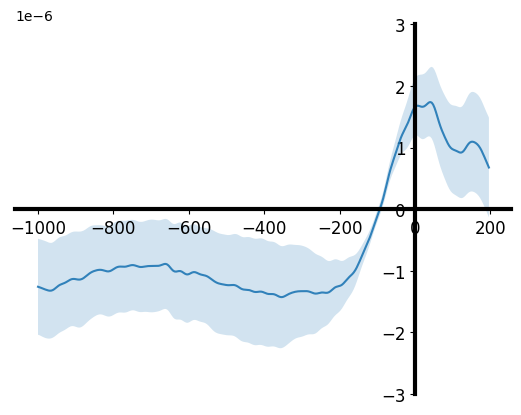

In [5]:
times = np.arange(-1000, 200, 1200/308)
y_min = -3e-6 
y_max = 3e-6  
plot_erp_results(erp_across_subjects, times, ylim=[y_min, y_max],labelpad=25)